# ANLP Assignment (Autumn 2020)

For assessment, you are expected to complete and submit this notebook file. When answers require code, you may import and use library functions (unless explicitly told otherwise). All of your own code should be included in the notebook rather than imported from elsewhere. Written answers should also be included in the notebook. You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers. If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data. In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell. Otherwise do not change the code in these cells.

In [9]:
candidateno=234722 #this MUST be updated to your candidate number so that you get a unique data sample

In [10]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [11]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/resources/')


In [12]:
#do not change the code in this cell
#preliminary imports

import re
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet_ic')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
brown_ic = wn_ic.ic("ic-brown.dat")

from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from sussex_nltk.corpus_readers import ReutersCorpusReader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet_ic.zip.
Sussex NLTK root directory is /content/drive/My Drive/Colab Notebooks/resources


# Question 1: Books vs DVDs

In this question, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

In [13]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [284]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'I': True, 'found': True, 'this': True, 'DVD': True, 'to': True, 'be': True, 'well': True, 'produced': True, 'and': True, 'engaging': True, 'go': True, 'along': True, 'with': True, 'the': True, 'POWERFUL': True, 'content': True, '.': True, 'Fantastic': True, 'Loads': True, 'of': True, 'deleted': True, 'scenes': True, 'that': True, 'are': True, 'very': True, 'worth': True, 'watching': True}, 'dvd')


a) Use your training data to find
i) the top 20 words which occur more frequently in book reviews than in dvd reviews
ii) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [10 marks]

## Pre-processing techniques used:


*   Case Normalization: I started by making all the letters in the text lower case. This will help with the consistency of the data. It also might help solve sparsity issues as we will be able to map more words to the same lowercase form.
*   Stopword Removal: Removing the stopwords from our text will help us focus on the words with higher information content. Stopwords largely exist in any form of text and are usually the words with the highest frequencies. However, most of the time they hold the least amount of information. Therefore removing them will decrease our set of tokens significantly while leading to better training.
*   Numerical Normalization: Replacing all the non-alphabatical tokens to 'NUM' will again help with sparsity issues. Our classes here do not really depend on any specific numerical value, so it will be useful to perform numerical normalization as the nunbers in the text hold little to no information about the corresponding class.
*   Lemmatization: Finally i perform lemmatization which replaces a word with its dictionary head word. This standardizes the vocabulary. I chose lemmatization over stemming because it's more reliable as it transforms the word into its actual root using a dictionary. On the other hand, stemming chops off words without checking if it leads to a proper word or not.




In [285]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
wl = WordNetLemmatizer() 

#function to preprocess the training and testing data
def normalizeSent(sentences):
  #apply case normalization
  lowered=[w.lower() for w in sentences]
  #remove stopwords and number from the text
  filtered_tokens = [w for w in lowered if w.isalpha() and not w.isdigit() and w not in stop]
  #lemmatize all the tokens in the text
  lemmtokens=[wl.lemmatize(word) for word in filtered_tokens]
  #return the preprocessed sentences as a list of tokens/words
  return lemmtokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [286]:
from nltk.probability import FreqDist

#function to calculate the frequency of each word in an input text
def bagofwordsFreq(trainingData):
  #initialize emppty lists, one for each class (Book and DVD)
  bookBags=[]
  dvdBags=[]

  #loop through every list of tokens in the training data
  for x in trainingData:
    #add the tokens to their corresponding list (depending on their class)
    if x[1]=='book':
      for k in x[0].keys():
        bookBags.append(k)
    else:
      for k in x[0].keys():
        dvdBags.append(k)
  #now we have a "bag" of tokens for each class
  #call the normalizeSent function to preprocess the bag of words
  filteredBooks=normalizeSent(bookBags)
  filteredDvd= normalizeSent(dvdBags)

  #call the builtin FreqDist function to have a word frequency representation for each of our normalized bag of words
  books_freqdist = FreqDist(filteredBooks)
  dvd_freqdist= FreqDist(filteredDvd)

  #return the 2 frequency representations
  return books_freqdist, dvd_freqdist

    

In [287]:
from nltk.probability import FreqDist
books_freqdist,dvd_freqdist = bagofwordsFreq(training_data)


In [288]:
#function to get the topk words that occur in one class more than the other
def most_frequent_words(posfreq,negfreq,topk):
    #create a list of tuples where the first element is the word 
    #and the second element is the difference of occurrence between the classes
    difference=[(w,f-negfreq.get(w,0)) for (w,f) in posfreq.most_common()]
    #sort the list in descending order
    sorteddiff=sorted(difference,key=lambda pair:pair[1],reverse=True)

    #return the first topk elements
    return sorteddiff[:topk]

In [289]:
topBooks=most_frequent_words(books_freqdist,dvd_freqdist,20)

In [290]:
topDVD=most_frequent_words(dvd_freqdist,books_freqdist,20)

b) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss i) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[15 marks]

## **WordList Classifier**
The wordlist classifier requires a list of words indicating the Book category, and a second list of words indicating the DVD category. Given Book and DVD word lists, a document's overall sentiment is determined based on counts of occurrences of words that occur in the two lists. 

I used the wordlists created in part A. Simply choosing the most frequent k words might not lead to the best results. However, by choosing words that occur more frequently in one domain than the other will lead to a more effective differentiation between the 2 classes. This way the words are more unique to their domain. 

In [291]:
traininglabelss=[x[1] for x in training_data]
books=0
dvd=0
for x in traininglabelss:
  if x=='book':
    books=books+1
  else:
    dvd=dvd+1
print(books)
print(dvd)

2683
3843


In [292]:
testinglabels=[x[1] for x in testing_data]
books=0
dvd=0
for x in testinglabels:
  if x=='book':
    books=books+1
  else:
    dvd=dvd+1
print(books)
print(dvd)

1151
1648


## **Evaluation Metrics, Accuracy vs F1 Score**

To decide on the length of my wordlist sample i trained the classifier several times using different lengths and compared the f1 scores and chose the length with the highest score. I used F1 score and not the accuracy because as demonstrated above we are dealing with unbalanced classes. Precision and recall are better measures for unbalanced classes, and the F1 score combines precision and recall by calculating their harmonic mean. 

In [293]:
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI): 

    def __init__(self, book, dvd):
        #initialize with the book wordlist 
        self._book = book 
        #initialize with the dvd wordlist
        self._dvd = dvd 

    #classifies one sentence 
    def classify(self, words): 
        score = 0
        
        
        #loop through each word in the input sentence
        for word in words:
            #calculate the score by deducting 1 if the word is found in the DVD bag of words, 
            #and adding 1 if the word is found in the BOOK bag of words
            if word in self._book:
                score+=1
            if word in self._dvd:
                score-=1
        #if the final score is less than 0 than label it as DVD otherwise label it as BOOK
        return "dvd" if score < 0 else "book" 

    #classifies a list of sentences
    def batch_classify(self, docs): 
        return [self.classify(doc.words() if hasattr(doc, 'words') else doc) for doc in docs] 

    def labels(self): 
        return ("book", "dvd")

In [294]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("book","dvd")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        #compare the prediction and goldstandars labels and calculate the true and false positive and the true and false negatives
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
            
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        
    
    def precision(self):
        #compute precision
        p=self.TP/(self.TP+self.FP)
        return p
    
    def recall(self):
        #compute recall
        r=self.TP/(self.TP+ self.FN)
        return r
    
    def f1(self):
        #compute F1 score
        f1= (2*self.precision()*self.recall())/(self.precision()+self.recall())
        return f1 

In [295]:
#function to normalize and classify the testing data
def classifyMe(classifier, test_data):
  #preprocess the testing data the same way the training data was normalized
  filteredData= [normalizeSent(sent) for sent in test_data] 
  #batch classify the normalized testing data
  testingpredictions=classifier.batch_classify(doc for doc in filteredData)
  #return the testing predictions
  return testingpredictions

In [296]:
#function to return accuracy, takes the predicted labels and the true labels
def classifier_evaluate(predictions,goldstandard):
  correct=0
  #compare the labels, if theyre the same add 1 to correct
  for (prediction,gold) in zip(predictions,goldstandard):
    if prediction ==gold:
      correct+=1
  #return accuracy (correctly labelled divided by the total length of the testing data)
  return correct/len(predictions)

In [297]:
#store the goldstandard testing labels
testingLabels=[x[1] for x in testing_data]

#store the testing data as a list of tokens for each sentence
testingDocs=[]
for x in testing_data:
  tokens=[]
  for k in x[0].keys():
    tokens.append(k)
  testingDocs.append(tokens)
  


In [298]:
#initialize a list with diff values for the length of the wordlist
lenWordlist=[5,10,20,30,40,50,60,70,80,90,100]
#initialize a max f1 score and an optimim length (k) 
maxF1=0
k=0
#for each length l
for l in lenWordlist:
  #get the top l words that occur in books more than dvd
  topBooks=most_frequent_words(books_freqdist,dvd_freqdist,l)
  #get the top l words that occur in dvd more than book
  topDVD=most_frequent_words(dvd_freqdist,books_freqdist,l)
  #create a list with the words only (without the difference value)
  bookData=[x[0] for x in topBooks]
  dvdData=[x[0] for x in topDVD]
  #train the wordlist classifier with book wordlist and the dvd wordlist
  classifier = SimpleClassifier(bookData,dvdData)
  #get the predictions on the testing data
  predictions=classifyMe(classifier, testingDocs)
  #initialize the confusion matrix (contains precision, recall, and F1 scores)
  cm=ConfusionMatrix(predictions, testingLabels)
  #check if the current f1 score is higher than the max recorded
  #it its higher uodate the max f1 score, maxF1, and the optimum length, k
  if cm.f1()>maxF1:
    maxF1=cm.f1()
    k=l

In [299]:
#get the optimum length
k

10

## Effect of K
The reason that lower ks perform better might be because this was the classifier is not overfitting. In addition, the more k features we add might be irrelevant or redundant that they  actually complicate the model rather than improve it. Adding more features will lead to the classifier 'memorizing' the training data and it will be more difficult to generalize on the testing data.

In [300]:
#use the optimum wordlist length,10, to train the wordlist classifier
topBooks=most_frequent_words(books_freqdist,dvd_freqdist,10)
topDVD=most_frequent_words(dvd_freqdist,books_freqdist,10)
bookData=[x[0] for x in topBooks]
dvdData=[x[0] for x in topDVD]
classifier = SimpleClassifier(bookData,dvdData)
predictions=classifyMe(classifier, testingDocs)
cm=ConfusionMatrix(predictions, testingLabels)
#calculate precision
cm.precision()

0.873794916739702

In [301]:
#calculate recall
cm.recall()

0.8662033014769766

In [302]:
#calculate f1 score
cm.f1()

0.8699825479930192

In [303]:
#calculate accuracy
classifier_evaluate(predictions,testingLabels)

0.893533404787424

c) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [10 marks]

In [304]:
#preprocess the training data and represent it in its original format, list of tuples: first element is a dictionary 
#with the tokens as keys and True as values, the second element is the corresponding class
normalizedTrainingData=[]
for tup in training_data:
  tokens=tup[0].keys()
  tokens=normalizeSent(tokens)
  dicTrue={}
  for token in tokens:
    dicTrue[token]=True
  normalizedTrainingData.append((dicTrue, tup[1]))

In [305]:
#preprocess the testing data and represent it in its original format, list of tuples: first element is a dictionary 
#with the tokens as keys and True as values, the second element is the corresponding class
normalizedTestingData=[]
for tup in testing_data:
  tokens=tup[0].keys()
  tokens=normalizeSent(tokens)
  dicTrue={}
  for token in tokens:
    dicTrue[token]=True
  normalizedTestingData.append((dicTrue, tup[1]))

In [306]:
#use nltk's naive bayes classifier and train it on the preprocessed training data
classifierNLTK = nltk.NaiveBayesClassifier.train(normalizedTrainingData)

#classify the testingdata
nltkpredictions=[]
for x in normalizedTestingData:
  label=classifierNLTK.classify(x[0])
  nltkpredictions.append(label)
#calculate the accuracy
acc=classifier_evaluate(nltkpredictions,testingLabels)
#confusion matrix for the nltk classifier
cm=ConfusionMatrix(nltkpredictions, testingLabels)
#calculate precision
p=cm.precision()
#calculate recall
r=cm.recall()
#calculate f1 score
fscore=cm.f1()

tracker=[]
tracker.append(["Naive", acc, p, r,fscore])


In [307]:
#use the optimum wordlist length,10, to train the wordlist classifier
topBooks=most_frequent_words(books_freqdist,dvd_freqdist,10)
topDVD=most_frequent_words(dvd_freqdist,books_freqdist,10)
bookData=[x[0] for x in topBooks]
dvdData=[x[0] for x in topDVD]
classifier = SimpleClassifier(bookData,dvdData)
predictions=classifyMe(classifier, testingDocs)
#calculate accuracy
acc=classifier_evaluate(predictions,testingLabels)

cm=ConfusionMatrix(predictions, testingLabels)
#calculate precision
p=cm.precision()
#calculate recall
r=cm.recall()
#calculate f1 score
fscore=cm.f1()
tracker.append(["Wordlist", acc, p, r,fscore])

In [308]:
#df to compare the performance of the 2 classifiers
df= pd.DataFrame(tracker, columns=["Classifier", "Accuracy", "Precision", "Recall", "F1 Score"])
display(df)

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Naive,0.931404,0.928508,0.902693,0.915419
1,Wordlist,0.893533,0.873795,0.866203,0.869983


## **Naive Bayes Classifier Results**
The results show that the naive bayes classifier performs slightly better than the wordlist classifier. A naive bayes classifier tends to work well in categorical tasks. A naive bayes classifier is fast and easy to build. It depends on probabilities. 

d) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [15 marks] 

## **Design Desicions**
The function 'sample' takes a random sample from the training data of a specified size. This randomness will lead to slightly different results on each run, because the training data is changing. To help generalize and decrease the effect of external factors and solely test the effect of the sample size, i recorded the **mean accuracy** and **mean f1 score** over 3 runs for each sample size.

In [309]:
len(training_data)

6526

In [310]:
import numpy as np
from random import sample
#initialize a list of different sample sizes ranging from 50 to 6550 and jump by 500
sampleSize=np.arange(50,6550, 500).tolist()

#initialize a list to the different accuracies and f1 scores
nltkTrainSize=[]

#loop through the different sample sizes
for s in sampleSize:
  accuracy=0
  currf1=0
  #run the classifier 3 times for every sample size and get the mean accuracy and f1 score
  for run in range(3):
    #train the naive bayes classifier using a sample of s sentences from the training data
    classifierNLTK = nltk.NaiveBayesClassifier.train(sample(normalizedTrainingData,s))
    #get the predictions on the testing data 
    nltklabels=[]
    for x in normalizedTestingData:
      label=classifierNLTK.classify(x[0])
      nltklabels.append(label)
    #accuracy
    accuracy=accuracy+classifier_evaluate(nltklabels,testingLabels)
    #confusion matrix
    cmnltk=ConfusionMatrix(nltklabels, testingLabels)
    #f1 score
    currf1= currf1+cmnltk.f1()
  #update the list with the sample size and its corresponding mean accuracy and mean f1 score
  nltkTrainSize.append([s,currf1/3,accuracy/3])


In [311]:
nltkTrainSize

[[50, 0.6864797769538421, 0.713469096105752],
 [550, 0.8905477573133673, 0.9103251161128975],
 [1050, 0.8686681221406364, 0.9007979040133381],
 [1550, 0.9036550470201762, 0.9216386804811242],
 [2050, 0.9110995409775674, 0.9260450160771705],
 [2550, 0.9066656972319893, 0.9248541145647255],
 [3050, 0.9083557656875995, 0.9260450160771704],
 [3550, 0.9109225464680367, 0.9272359175896153],
 [4050, 0.915643619300603, 0.9314040728831726],
 [4550, 0.9159463016143405, 0.931761343336906],
 [5050, 0.9120052296391646, 0.9290222698582826],
 [5550, 0.9141959933688311, 0.9302131713707276],
 [6050, 0.9166091629834319, 0.9322377039418841]]

In [312]:
df=  pd.DataFrame(nltkTrainSize, columns=["Training Size", "f1 Score", "accuracy"])
display(df)

,Training Size,f1 Score,accuracy
0,50,0.686480,0.713469
1,550,0.890548,0.910325
2,1050,0.868668,0.900798
3,1550,0.903655,0.921639
4,2050,0.911100,0.926045
5,2550,0.906666,0.924854
6,3050,0.908356,0.926045
7,3550,0.910923,0.927236
8,4050,0.915644,0.931404
9,4550,0.915946,0.931761


In [313]:
#initialize a list to the different accuracies and f1 scores
wordlistTrainSize=[]

#loop through the different sample sizes
for s in sampleSize:
  accuracy=0
  currf1=0
  #run the classifier 3 times for every sample size and get the mean accuracy and f1 score
  for run in range(3):
    #train the naive bayes classifier using a sample of s sentences from the training data
    booksSample,dvdSample=bagofwordsFreq(sample(training_data,s))
    topBooks=most_frequent_words(booksSample,dvdSample,10)
    topDVD=most_frequent_words(dvdSample,booksSample,10)
    bookData=[x[0] for x in topBooks]
    dvdData=[x[0] for x in topDVD]
    classifier = SimpleClassifier(bookData,dvdData)
    #get the predictions on the testing data
    traininglabels=classifyMe(classifier, testingDocs)
    #confusion matrix
    cm=ConfusionMatrix(traininglabels, testingLabels)
    #f1 score
    currf1=currf1+cm.f1()
    #accuracy
    accuracy=accuracy+classifier_evaluate(traininglabels,testingLabels)
  #update the list with the sample size and its corresponding mean accuracy and mean f1 score
  wordlistTrainSize.append([s,currf1/3,accuracy/3])
 



In [314]:
wordlistTrainSize

[[50, 0.802348602893371, 0.8327974276527331],
 [550, 0.8672483605122253, 0.8891270691913779],
 [1050, 0.874941906120091, 0.8934143146361796],
 [1550, 0.8701332928649114, 0.893533404787424],
 [2050, 0.8719859825302686, 0.894247945694891],
 [2550, 0.8736851697888032, 0.8954388472073359],
 [3050, 0.8718338588909113, 0.8944861259973801],
 [3550, 0.8696034706300594, 0.8931761343336907],
 [4050, 0.8736851697888032, 0.8954388472073359],
 [4550, 0.8699825479930192, 0.893533404787424],
 [5050, 0.8699825479930192, 0.893533404787424],
 [5550, 0.8718338588909113, 0.8944861259973801],
 [6050, 0.8699825479930192, 0.893533404787424]]

In [315]:
df2 = pd.DataFrame(wordlistTrainSize, columns=["Training Size", "f1 Score", "accuracy"])
display(df2)

,Training Size,f1 Score,accuracy
0,50,0.802349,0.832797
1,550,0.867248,0.889127
2,1050,0.874942,0.893414
3,1550,0.870133,0.893533
4,2050,0.871986,0.894248
5,2550,0.873685,0.895439
6,3050,0.871834,0.894486
7,3550,0.869603,0.893176
8,4050,0.873685,0.895439
9,4550,0.869983,0.893533


In [316]:
finaldf=pd.DataFrame()
finaldf["Training Size"]=df["Training Size"]
finaldf["Wordlist F1 Score"]=df2["f1 Score"]
finaldf["Naive F1 Score"]=df["f1 Score"]
display(finaldf)

,Training Size,Wordlist F1 Score,Naive F1 Score
0,50,0.802349,0.686480
1,550,0.867248,0.890548
2,1050,0.874942,0.868668
3,1550,0.870133,0.903655
4,2050,0.871986,0.911100
5,2550,0.873685,0.906666
6,3050,0.871834,0.908356
7,3550,0.869603,0.910923
8,4050,0.873685,0.915644
9,4550,0.869983,0.915946


(0.0, 1.0)

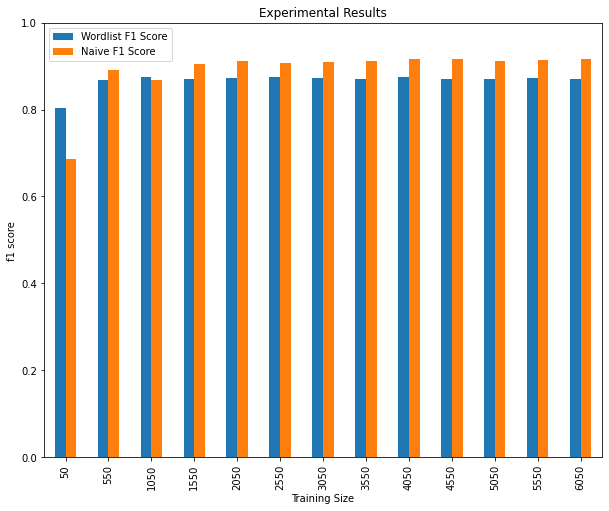

In [317]:
ax = finaldf.plot(kind="bar",title="Experimental Results",x="Training Size",ylabel= "f1 score",figsize=(10, 8))

ax.set_ylim(0,1.0)

In [318]:
finaldf=pd.DataFrame()
finaldf["Training Size"]=df["Training Size"]
finaldf["Wordlist accuracy"]=df2["accuracy"]
finaldf["Naive accuracy"]=df["accuracy"]
display(finaldf)

,Training Size,Wordlist accuracy,Naive accuracy
0,50,0.832797,0.713469
1,550,0.889127,0.910325
2,1050,0.893414,0.900798
3,1550,0.893533,0.921639
4,2050,0.894248,0.926045
5,2550,0.895439,0.924854
6,3050,0.894486,0.926045
7,3550,0.893176,0.927236
8,4050,0.895439,0.931404
9,4550,0.893533,0.931761


(0.0, 1.0)

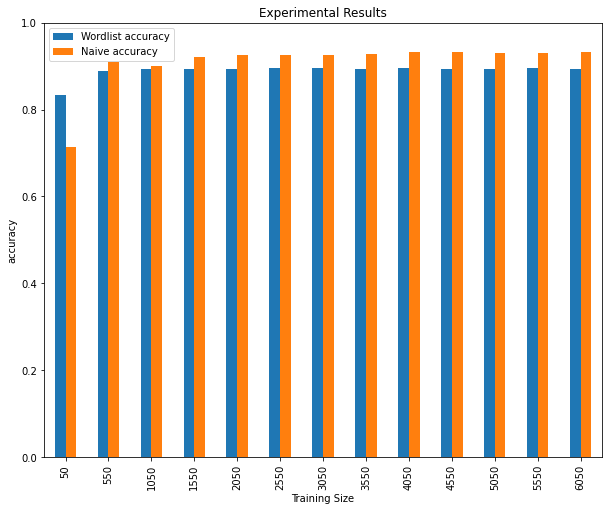

In [319]:
ax = finaldf.plot(kind="bar",title="Experimental Results",x="Training Size",ylabel= "accuracy",figsize=(10, 8))

ax.set_ylim(0,1.0)

## **Effect of sample size**

The results show:


*   Wordlist classifiers perform better than naive bayes classifiers when the amount of training data is low.
*   At the beginning (from 50 to 500) an increase in the training sample will increase the accuracy and f1 scores a lot, however we reach a point where it doesnt really matter. 

More data is usually better as it decreases the chance of overfitting. Having a small training sample size will make your classifier learn fake correlations that are only true for this instance of training data, hence it will make it harder to generalize. Increasing the training data might have a negative effect only if the data is noisy or if it does not properly match the class its trying to represent. This is not the case here so increasing the data does not decrease the performance of our classifiers but it does not increase it also. 



# Question 2: Distributional Semantics

In this question, you will be investigating the *distributional hypothesis*: **words which appear in similar contexts tend to have similar meanings**.

We are going to be using the Reuters corpus of financial documents for this part of the assignment.  When you run the following cell you should see that it contains 1,113,359 sentences.

In [14]:
#do not change the code in this cell
rcr = ReutersCorpusReader().finance()
rcr.enumerate_sents()

1113359

The following cell will take 2-5 minutes to run.  It will generate a unique-to-you sample of 200,000 sentences.  These sentences are tokenised and normalised for case and number for you.

In [15]:
#do not change the code in this cell
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

random.seed(candidateno)  
samplesize=2000
iterations =100
sentences=[]
for i in range(0,iterations):
    sentences+=[normalise(sent) for sent in rcr.sample_sents(samplesize=samplesize)]
    print("Completed {}%".format(i))
print("Completed 100%")


Completed 0%
Completed 1%
Completed 2%
Completed 3%
Completed 4%
Completed 5%
Completed 6%
Completed 7%
Completed 8%
Completed 9%
Completed 10%
Completed 11%
Completed 12%
Completed 13%
Completed 14%
Completed 15%
Completed 16%
Completed 17%
Completed 18%
Completed 19%
Completed 20%
Completed 21%
Completed 22%
Completed 23%
Completed 24%
Completed 25%
Completed 26%
Completed 27%
Completed 28%
Completed 29%
Completed 30%
Completed 31%
Completed 32%
Completed 33%
Completed 34%
Completed 35%
Completed 36%
Completed 37%
Completed 38%
Completed 39%
Completed 40%
Completed 41%
Completed 42%
Completed 43%
Completed 44%
Completed 45%
Completed 46%
Completed 47%
Completed 48%
Completed 49%
Completed 50%
Completed 51%
Completed 52%
Completed 53%
Completed 54%
Completed 55%
Completed 56%
Completed 57%
Completed 58%
Completed 59%
Completed 60%
Completed 61%
Completed 62%
Completed 63%
Completed 64%
Completed 65%
Completed 66%
Completed 67%
Completed 68%
Completed 69%
Completed 70%
Completed 71%
Co

`generate_features()` will used and explored below.

In [16]:
# do not change the code in this cell
def generate_features(sentences,window=1):
  
    mydict={}
    for sentence in sentences:
        #look at each token and its positional index, i
        for i,token in enumerate(sentence):
            #get the value of the current token, if not in the dictionary yet set it to an empty dictionary {}
            current=mydict.get(token,{})
            #create a list of 'co-occuring' features consisting of all the neighbouring words within the specified window of the current token
            features=sentence[max(0,i-window):i]+sentence[i+1:i+window+1]
            
            #each token is a key to a dictionary of feature value pairs
            #add all the unique word features to the dictionary of the current token as keys and their corresponding co-occurring frequencies as values
            for feature in features:
                current[feature]=current.get(feature,0)+1
            mydict[token]=current
    return mydict

a) Run `generate_features(sentences[:5])`. With reference to the code and the specific examples, explain how the output was generated [5 marks]

**generate_features function** is described in the comments above. It takes a list of sentences and a window size and returns a dictionary of dictionaries, where the key to the outer dictionary is the words in the corpus and the key to each internal dictionary is a another word (a co-occurrence feature). The value in the internal dictionary should be the number of the times the words co-occur together (within the given window).

In [17]:
generate_features(sentences[:5])

{"''": {',': 1, '.': 1, 'he': 1},
 '(': {'bln': 1, 'cpi': 1, 'exports': 1, 'index': 1},
 ')': {'apr': 1, 'cpi': 1, 'on': 1, 'pts': 1},
 ',': {"''": 1,
  'NUM': 3,
  'age-bracket': 1,
  'or': 1,
  'organisation': 1,
  'so': 1},
 '-': {'-': 2, '1,097.1': 1},
 '.': {"''": 1, 'deficit-raines': 1, 'forward': 1, 'said': 1, 'tuesday': 1},
 '1,097.1': {'-': 1, '1,291.9': 1},
 '1,291.9': {'1,097.1': 1, '1,357.1': 1},
 '1,357.1': {'1,291.9': 1, 'apr': 1},
 'NUM': {',': 3, 'about': 1, 'even': 1, 'percent': 1},
 '``': {'i': 1, 'the': 1},
 'a': {'common': 1, 'finding': 1},
 'about': {'NUM': 1, 'see': 1},
 'age-bracket': {',': 1, 'that': 1},
 'an': {'of': 1, 'unexpectedly': 1},
 'and': {'jospin': 1, 'kohl': 1},
 'apr': {')': 1, '1,357.1': 1},
 'be': {'happy': 1, 'would': 1},
 'bln': {'(': 1, 'pts': 1},
 'can': {'renew': 1, 'you': 1},
 'common': {'a': 1, 'way': 1},
 'consumer': {'june': 1, 'price': 1},
 'cpi': {'(': 1, ')': 1},
 'cut': {'deficit-raines': 1, 'to': 1},
 'deficit-raines': {'.': 1, 'cut'

## **Example from the output above**
The above output shows that the token 'a' co-occured with feature 'common' once and with feature 'finding' also once in the first 5 sentences of our data. Since the window size here is 1 then these 2 features were right next to 'a' when they cooccurred together.

b) Write code and **find** the 1000 most frequently occurring words that
* are in your sample; AND
* have at least one noun sense according to WordNet [5 marks]

In [19]:
#represent the sentences as a list of tokens
bagoftokens=[]
for sent in sentences:
  for token in sent:
    bagoftokens.append(token)


#initialize a dictionary to story the word frequency pairs
freqTokens={}
#calculate and store the frequency of each unique word in the list of word frequency pair
for token in bagoftokens:
  freqTokens[token]= freqTokens.get(token,0)+1

In [20]:
len(freqTokens)

63167

In [21]:
#sort the dictionary in descending order based on its values 
sortedFreq = dict(sorted(freqTokens.items(), key=lambda kv: kv[1], reverse=True))

In [22]:
#initialize a dictionary to store the top 1000 most occurring words with a noun sense
top1000Dict={}
counter=0

#for each token in the keys of the dictionary
for token in sortedFreq.keys():
  #if our dictionary still does not contain 1000 words
  if counter<1000:
    #get the list of noun synsets of token
    wordSyns=wn.synsets(token,wn.NOUN)
    #if the list of nouns synsets is not empty (if its empty the word does not have a noun sense)
    if len(wordSyns) !=0:
      counter=counter+1
      #add the token with its frequency value to the dictionary
      top1000Dict[token]=sortedFreq[token]
  
  #when we have our 1000 words break the loop
  else:
    break


In [23]:
# do not change the code in this cell.  It relates to part c)
wordpair=("house","garden")
concept_1=wn.synsets(wordpair[0])[0]
concept_2=wn.synsets(wordpair[1])[0]
print("Path similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.path_similarity(concept_1,concept_2)))
print("Resnik similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.res_similarity(concept_1,concept_2, brown_ic)))
print("Lin similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.lin_similarity(concept_1,concept_2, brown_ic)))

Path similarity between 1st sense of house and 1st sense of garden is 0.08333333333333333
Resnik similarity between 1st sense of house and 1st sense of garden is 1.2900256809649917
Lin similarity between 1st sense of house and 1st sense of garden is 0.15380807721262396


c) 
i) The code above outputs the path similarity score, the Resnik similarity score and the Lin similarity score for a pair of concepts in WordNet.  Explain what each of these numbers means.

ii) For every possible pair of words identified in Q2, determine the semantic similarity of the pair according to WordNet.  Make sure you justify your choice of semantic similarity measure and explain and justify the strategy used for words with multiple senses.

iii) Identify the 10 most similar words (according to WordNet) to the most frequent word in the corpus [15 marks]

##**Similarity Function**


*   parameters: word pair and the similarity measure ('path', 'res', or 'lin')
*   the function calculates the semantic simalirty between all the possible pair of noun senses of the words and returns the max simaliry measure
*   We return the max similarity measure because: The similarity of two words with a given part of speech is defined as the **MAXIMUM** similarity of all possible sense pairings.








In [25]:
#function the calculates the similarity between 2 words, takes as a parameter the choice of the semantic simalirty measure 
def word_similarity(w1, w2, measure="lin"):
  #list of all the noun senses of the w1 and w2
  n1=wn.synsets(w1,wn.NOUN)
  n2=wn.synsets(w2,wn.NOUN)
  
  
  #for each noun sense in w1
  for syn1 in n1:
    maxSim=0
    #for each noun sense in w2
    for syn2 in n2:
      #calculate the similarity
      if (measure=="path"):
        curr=wn.path_similarity(syn1,syn2)
      elif (measure=="lin"):
        curr=wn.lin_similarity(syn1,syn2,brown_ic)
      elif (measure=="res"):
        curr=wn.res_similarity(syn1,syn2,brown_ic)
      #take the max simaliry if more than one noun senses exists
      if curr>maxSim:
        maxSim=curr
  return maxSim

## **Path Similarity Measure**


*   Based on the intuition that more similar concept(words) are closeer together in the hierarchy.
*   The shorter the path between 2 words in the hierarchy the greater the similarity between them.
*   Equation: sim(synsetA,synsetB)=1/(1+lengthOfPath(synsetA,synsetB))









In [149]:

startTime=time.time()

#paths Similarity for all pair of words in the top 1000
pathsimList=[]
counter=0
for word in top1000Dict.keys():
  counter=counter +1
  #to monitor progress
  print(counter)
  for word2 in top1000Dict.keys():
    #update the list with a tuple where the first and second elements are the pair of words being compared and the third element is their path similarity
    pathsimList.append((word,word2,word_similarity(word,word2, "path")))
finishTime=time.time()
#execution time
pathTime=finishTime-startTime


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [151]:
pathTime

2639.4668786525726

In [152]:
pathsimList[:30]

[('in', 'in', 1.0),
 ('in', 'a', 0.0625),
 ('in', 'percent', 0.058823529411764705),
 ('in', 'it', 0.05555555555555555),
 ('in', 'be', 0.07142857142857142),
 ('in', 'pct', 0.058823529411764705),
 ('in', 'at', 0.07692307692307693),
 ('in', 'was', 0.3333333333333333),
 ('in', 'will', 0.0625),
 ('in', 'as', 0.16666666666666666),
 ('in', 'he', 0.07692307692307693),
 ('in', 'bank', 0.09090909090909091),
 ('in', 'year', 0.06666666666666667),
 ('in', 'have', 0.08333333333333333),
 ('in', 'are', 0.0625),
 ('in', 'million', 0.06666666666666667),
 ('in', 'has', 0.09090909090909091),
 ('in', 'may', 0.058823529411764705),
 ('in', 'its', 0.05555555555555555),
 ('in', 'government', 0.0625),
 ('in', 'an', 0.05555555555555555),
 ('in', 'billion', 0.06666666666666667),
 ('in', 'uk', 0.14285714285714285),
 ('in', 'tax', 0.058823529411764705),
 ('in', 'rate', 0.07142857142857142),
 ('in', 'trade', 0.06666666666666667),
 ('in', 'budget', 0.058823529411764705),
 ('in', 'more', 0.07142857142857142),
 ('in', 

## **Results of Path Simaliry Measure:**


*   The algorithm takes so long to run.
*   This measure does not differentiate between different types if paths, concepts are less similar higher up the hierarchy.
*   Does not take into consideration that some parts of the hierarchy may be denseky populated with rare terminology.






## **Resnik Similarity Measure**



*   Similarity based on what 2 concepts(words) share.
*   Based on the notion of information content.
*   The information content of a concept(word) is negative log of the probability of finding the concept(word) in a given corpus.
*   Resnik similarity is the information content of what the 2 concepts share, their lowest common subsumer.
*   simRes(w1,w2)= IC(LCS(w1,w2)





In [153]:
startTime=time.time()
#Resnik Similarity for all pair of words in the top 1000
ressimList=[]
counter=0
for word in top1000Dict.keys():
  counter=counter +1
  #to monitor progress
  print(counter)
  for word2 in top1000Dict.keys():
    #update the list with a tuple where the first and second elements are the pair of words being compared and the third element is their resnik similarity
    ressimList.append((word,word2,word_similarity(word,word2, "res")))
finishTime=time.time()
#execution time
resTime=finishTime-startTime

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [154]:
resTime

99.70135402679443

In [155]:
ressimList[:30]

[('in', 'in', 11.469867639508397),
 ('in', 'a', 0.8017591149538994),
 ('in', 'percent', 0),
 ('in', 'it', 0),
 ('in', 'be', 0.8017591149538994),
 ('in', 'pct', 0),
 ('in', 'at', 0.8017591149538994),
 ('in', 'was', 5.069028967795536),
 ('in', 'will', 0),
 ('in', 'as', 4.31904854177692),
 ('in', 'he', 0.8017591149538994),
 ('in', 'bank', 1.2900256809649917),
 ('in', 'year', 0),
 ('in', 'have', 1.2900256809649917),
 ('in', 'are', 0),
 ('in', 'million', 0),
 ('in', 'has', 3.0115861627720086),
 ('in', 'may', 1.2900256809649917),
 ('in', 'its', 0),
 ('in', 'government', 0),
 ('in', 'an', 0),
 ('in', 'billion', 0),
 ('in', 'uk', 4.389167965544902),
 ('in', 'tax', 0),
 ('in', 'rate', 0),
 ('in', 'trade', 0.8017591149538994),
 ('in', 'budget', 0),
 ('in', 'more', 1.2900256809649917),
 ('in', 'growth', 1.2900256809649917),
 ('in', 'last', 1.2900256809649917)]

## **Results of Resnik Simaliry Measure:**

*   As shown the time decreased significantly.
*   Resnik similairty measure resulted in so many different word pairs sharing the same simalirty value. This is a result of many concepts sharing the same lowest common subsumer.
*   This can be improved by the following similarity measure.





## **Lin Similarity Measure**



*   Same as Resnik but takes into consideration the information content of the individual words/concept being compared.
*   Its the ratio of shared information content to total information content.
*   simLin(w1,w2)= (2 * simRes(w1,w2)) / (IC(w1) + IC(w2))

In [26]:
import time

startTime= time.time()
#Lin Similarity for all pair of words in the top 1000
linsimList=[]
counter=0
for word in top1000Dict.keys():
  counter=counter +1
  #to monitor progress
  print(counter)
  for word2 in top1000Dict.keys():
    #update the list with a tuple where the first and second elements are the pair of words being compared and the third element is their lin similarity
    linsimList.append((word,word2,word_similarity(word,word2, "lin")))
finishTime=time.time()
#execution time
linTime=finishTime-startTime

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [27]:
linTime

108.13680768013

In [28]:
linsimList[:30]

[('in', 'in', 1.0),
 ('in', 'a', 0.06641557396123841),
 ('in', 'percent', 0),
 ('in', 'it', 0),
 ('in', 'be', 0.09324552021879072),
 ('in', 'pct', 0),
 ('in', 'at', 1.6035182299077988e-300),
 ('in', 'was', 0.6062080080943216),
 ('in', 'will', 0),
 ('in', 'as', 0.35777839318366556),
 ('in', 'he', 0.07643211189878533),
 ('in', 'bank', 0.12704701947077837),
 ('in', 'year', 0),
 ('in', 'have', 0.14607603581720022),
 ('in', 'are', 0),
 ('in', 'million', 0),
 ('in', 'has', 0.33213163679495317),
 ('in', 'may', 0.13803004662656923),
 ('in', 'its', 0),
 ('in', 'government', 0),
 ('in', 'an', 0),
 ('in', 'billion', 0),
 ('in', 'uk', 0.4031089422448722),
 ('in', 'tax', 0),
 ('in', 'rate', 0),
 ('in', 'trade', 0.07627515191806303),
 ('in', 'budget', 0),
 ('in', 'more', 0.11138733578105559),
 ('in', 'growth', 0.1226398428695784),
 ('in', 'last', 0.1320154886881688)]

## **Results of Lin Similarity Measure:**

*   As shown the time is not really affected from the previous measure.
*   However, looking at the similarity values, we see less word pairs having the same exact similairty value.

Therefore, i will use the Lin similarity measure.


## **Display Results in DataFrame**

In [206]:
linList=linsimList[:30]
pathList=pathsimList[:30]
resList=ressimList[:30]
compareDf=pd.DataFrame()
word1List=[tup[0] for tup in linList]

word2List=[tup[1] for tup in linList]
linMeasure=[tup[2] for tup in linList]
resMeasure=[tup[2] for tup in resList]
pathMeasure=[tup[2] for tup in pathList]
compareDf['word1']=word1List
compareDf['word2']=word2List
compareDf['lin']=linMeasure
compareDf['res']=resMeasure
compareDf['path']=pathMeasure

display(compareDf)

,word1,word2,lin,res,path
0,in,in,1.000000e+00,11.469868,1.000000
1,in,a,6.641557e-02,0.801759,0.062500
2,in,percent,0.000000e+00,0.000000,0.058824
3,in,it,0.000000e+00,0.000000,0.055556
4,in,be,9.324552e-02,0.801759,0.071429
5,in,pct,0.000000e+00,0.000000,0.058824
6,in,at,1.603518e-300,0.801759,0.076923
7,in,was,6.062080e-01,5.069029,0.333333
8,in,will,0.000000e+00,0.000000,0.062500
9,in,as,3.577784e-01,4.319049,0.166667


## **Spearsman Rank Correlation Coefficient** between different similarity measures

In [207]:
compareDf.corr(method='spearman')

,lin,res,path
lin,1.000000,0.99317,0.795196
res,0.993170,1.00000,0.808630
path,0.795196,0.80863,1.000000


## **Correlation Scatter Plot**

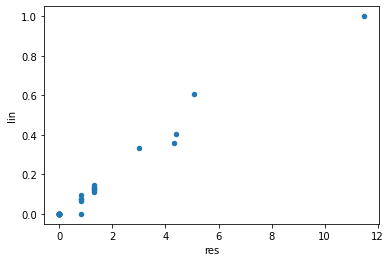

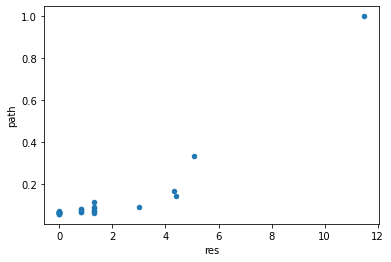

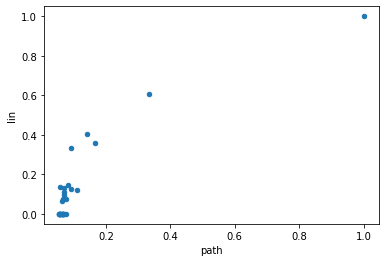

In [170]:
def draw_scatter(x,y):

    compareDf[x]=compareDf[x].map(float)
    compareDf[y]=compareDf[y].map(float)
    
    compareDf.plot.scatter(x,y)
draw_scatter('res','lin')
draw_scatter('res','path')
draw_scatter('path','lin')

It shows **positive correlation** between all the similarity measures, with resnick and lin similarity measure the most correlated

In [29]:
#initialize empty
freqList={}
#for each tuple in the lin similarity list
for tup in linsimList:
  #check if the first word in the tuple is the most frequent word in the top1000 nouns
  if tup[0]==list(top1000Dict.keys())[0]:
    #if it is add the second word and the corresponding lin similarity value to our dictionary
    freqList[tup[1]]=tup[2]


In [30]:
len(freqList)

1000

In [31]:
#sort the dictionary in descending order
sortedFreqList=list(sorted(freqList.items(), key=lambda kv: kv[1], reverse=True))

In [32]:
#get the 10 most similar words
mostSimilar=sortedFreqList[:10]
mostSimilar

[('in', 1.0),
 ('was', 0.6062080080943216),
 ('washington', 0.6062080080943216),
 ('state', 0.60551929298177),
 ('states', 0.60551929298177),
 ('district', 0.5470987992065358),
 ('country', 0.49867275686764123),
 ('countries', 0.49867275686764123),
 ('city', 0.4982955561639145),
 ('de', 0.4804952241223572)]

d)
i) Write code to construct distributional vector representations of words in the corpus with a parameter to specify context size.  Explain how you calculate the value of association between each word and each context feature.

ii) Use your code to construct representations of the 1000 words identified in Q2 with a window size of 1 and thus determine the 10 words which are distributionally most similar to the most frequent word in the corpus. [10 marks]

In [33]:
#same functionality as the generate_features function above but return 2 extra dictionaries: 
#feattotals(row total of each feature) and wordtotals(column total of each word in corpus)
def generate_featuresEdited(sentenes,window):
  
  #the frequency of each feature: a dictionary of integers (with the same keys as the dictionaries indexed by reps)
  feattotals={}
  #the frequency of each word: a dictionary of integers (with the same keys as reps)
  wordtotals={}
  #the feature representations: a dictionary of dictionaries, the same as in question 2a
  reps={}
  for sentence in sentences:
    for i,token in enumerate(sentence):
      current=reps.get(token,{})
      features=sentence[max(0,i-window):i]+sentence[i+1:i+window+1]
      for feature in features:
        current[feature]=current.get(feature,0)+1
        feattotals[feature]=feattotals.get(feature,0)+1
      wordtotals[token]=wordtotals.get(token,0)+len(features)
      reps[token]=current
  return feattotals, wordtotals, reps

## **PPMI**


*   Intuition: some features are more informative that others
*   PMI measures the amount of information gained by seeing a word and a feature together.
*   If a feature co-occurs with a target word more than we expect, if words and features occured independently, then it has more weight in the similarity calculation.
*   PMI Equation: 
\begin{eqnarray*}
PMI(word,feat) = \frac{\mbox{freq}(word,feat) \times \Sigma_{w*,f*} \mbox{freq}(w*,f*)}{\Sigma_{f*} \mbox{freq}(word,f*) \times \Sigma_{w*} \mbox{freq}(w*,feat)}
\end{eqnarray*}
*   Use positive PMI to ignore when cooccurrence frequency is 0.
\begin{eqnarray*}
\mbox{PPMI}(word,feat)=
\begin{cases}PMI(word,feat),& \mbox{if PMI}(word,feat)>0\\
=0,& \mbox{otherwise}
\end{cases}
\end{eqnarray*}








In [34]:
def convert_to_ppmi(sentences,window):
  feattotals,wordtotals,reps=generate_featuresEdited(sentences,window)
  #sum of all co-occurrences 
  grandtotal=sum(wordtotals.values())
  ppmi={word:{feat:max(0,math.log((freq*grandtotal)/(wordtotals[word]*feattotals[feat]),2)) for (feat,freq) in rep.items()} for (word,rep) in reps.items()}
  return ppmi
        

In [35]:
ppmi=convert_to_ppmi(sentences,1)

In [36]:
#convert the whole sentences' ppmi to a dictrionary of the top 1000 noun words and their corresponding dictionary of features
topreps={}
for word in ppmi.keys():
  if word in top1000Dict.keys():
    topreps[word]=ppmi[word]



In [37]:
len(topreps)

1000

In [38]:
#topWord is a dictionary of the co-occurence features and their frequency values of the most frequent noun 
topWord=topreps[list(top1000Dict.keys())[0]]

In [39]:
list(top1000Dict.keys())[0]

'in'

In [40]:
#sort topWord in descending order
sortedTopWord=list(sorted(topWord.items(), key=lambda kv: kv[1], reverse=True))

In [41]:
#print the most similar 10 words
sortedTopWord[:10]

[('vogue', 5.8177747377253715),
 ('*amounts', 5.8177747377253715),
 ('bullock-carts', 5.8177747377253715),
 ('defect', 5.8177747377253715),
 ('gyrations', 5.8177747377253715),
 ('call-features', 5.8177747377253715),
 ('**trend', 5.8177747377253715),
 ('gold-', 5.8177747377253715),
 ('kandahar', 5.8177747377253715),
 ('policymarkers', 5.8177747377253715)]

e) Plan and carry out an investigation into the correlation between semantic similarity according to WordNet and distributional similarity with different context window sizes. You should make sure that you include a graph of how correlation varies with context window size and that you discuss your results. [15 marks]

In order to evaluate the different similarity measures, we tend to calculate correlation between human judgements and the obtained similarity measures. Since we don't have human judgement here, i will be calculating the correlation between PPMI with different window size and lin similarity measure. I will also calculate the correlation between PPMIS of different window sizes. 

I will use **Spearsman Rank Correlation Coefficient**.

In [42]:
#function that converts ppmi to a list of tuples
def convertPPMItoList(ppmi):
  ppmiReps=[]
  for k in ppmi.keys():
    for key2 in ppmi[k].keys():
      tupl=(k,key2,ppmi[k][key2])
      ppmiReps.append(tupl)
  return ppmiReps


In [43]:
#function to get the common word pairs and their corresponding values between 2 lists of similarity measures 
def getCommonPairs(list1, list2):
  reps1=[]
  reps2=[]
  for tup in list1:
    if tup[0] in list2.keys():
      if tup[1] in list2[tup[0]].keys():
        reps2.append((tup[0],tup[1],list2[tup[0]][tup[1]]))
        reps1.append((tup[0],tup[1],tup[2]))
  return reps1, reps2

In [44]:
ppmi1=ppmi
ppmi2=convert_to_ppmi(sentences,2)
ppmi3=convert_to_ppmi(sentences,3)


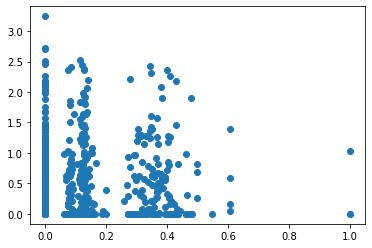

In [254]:
import matplotlib.pyplot as plt

#scatter plot of ppmi of window size 3 with lin similarity measure
reps1, reps2=getCommonPairs(linsimList,ppmi3)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [255]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['ppmi window 3']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,ppmi window 3
lin sim,1.000000,0.013658
ppmi window 3,0.013658,1.000000


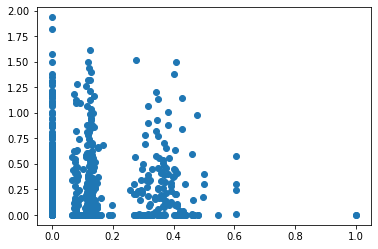

In [252]:
#scatter plot of ppmi of window size 10 with lin similarity measure
ppmi10=convert_to_ppmi(sentences,10)
reps1, reps2=getCommonPairs(linsimList,ppmi10)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [253]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['ppmi window 10']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,ppmi window 10
lin sim,1.000000,0.006366
ppmi window 10,0.006366,1.000000


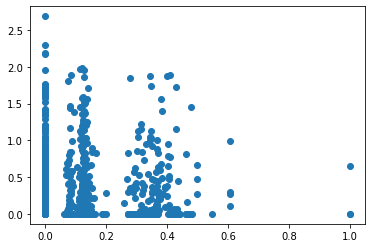

In [45]:
#scatter plot of ppmi of window size 5 with lin similarity measure
ppmi5=convert_to_ppmi(sentences,5)
reps1, reps2=getCommonPairs(linsimList,ppmi5)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [46]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['ppmi window 5']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,ppmi window 5
lin sim,1.0000,0.0083
ppmi window 5,0.0083,1.0000


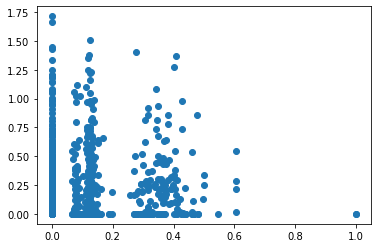

In [248]:
#scatter plot of ppmi of window size 13 with lin similarity measure
ppmi13=convert_to_ppmi(sentences,13)
reps1, reps2=getCommonPairs(linsimList,ppmi13)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [249]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['ppmi window 13']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,ppmi window 13
lin sim,1.000000,0.006016
ppmi window 13,0.006016,1.000000


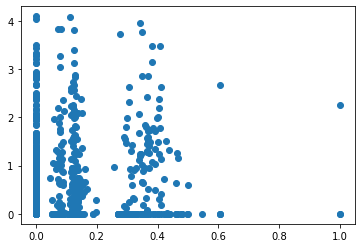

In [47]:
#scatter plot of ppmi of window size 1 with lin similarity measure
reps1, reps2=getCommonPairs(linsimList,ppmi1)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [48]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['ppmi window 1']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,ppmi window 1
lin sim,1.000000,0.038379
ppmi window 1,0.038379,1.000000


After Observing the scatter plots and correlation coefficient, i realized that semantic similarity and distributional similarity have little to no correlation with one another. 

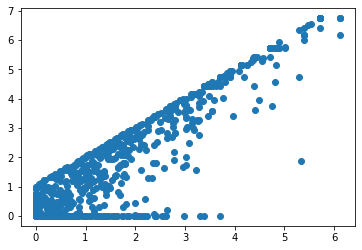

In [244]:
#scatter plot of window size 1 with window size 2
ppmilist2=convertPPMItoList(ppmi2)
reps1, reps2=getCommonPairs(ppmilist2,ppmi1)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [245]:
scatterDF=pd.DataFrame()
scatterDF['window2']=[tup[2] for tup in reps1]
scatterDF['window1']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,window2,window1
window2,1.000000,0.980887
window1,0.980887,1.000000


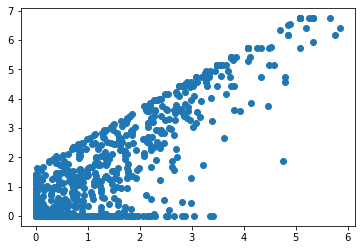

In [280]:
#scatter plot of window size 1 with window size 3
ppmilist3=convertPPMItoList(ppmi3)
reps1, reps2=getCommonPairs(ppmilist3,ppmi1)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [281]:
scatterDF=pd.DataFrame()
scatterDF['window3']=[tup[2] for tup in reps1]
scatterDF['window1']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,window3,window1
window3,1.000000,0.968104
window1,0.968104,1.000000


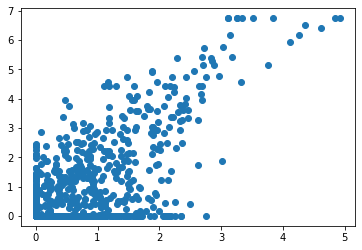

In [238]:
#scatter plot of window size 1 with window size 10
ppmilist10=convertPPMItoList(ppmi10)
reps1, reps2=getCommonPairs(ppmilist10,ppmi1)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [239]:
scatterDF=pd.DataFrame()
scatterDF['window10']=[tup[2] for tup in reps1]
scatterDF['window1']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,window10,window1
window10,1.000000,0.921691
window1,0.921691,1.000000


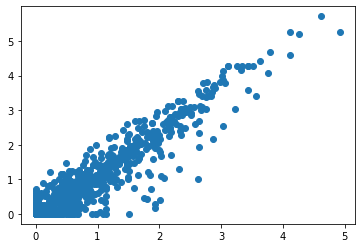

In [240]:
#scatter plot of window size 5 with window size 10
ppmilist10=convertPPMItoList(ppmi10)
reps1, reps2=getCommonPairs(ppmilist10,ppmi5)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [241]:
scatterDF=pd.DataFrame()
scatterDF['window10']=[tup[2] for tup in reps1]
scatterDF['window5']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,window10,window5
window10,1.000000,0.975895
window5,0.975895,1.000000


Closer window sizes have higher correlation, which is expected as they have almost the same cooccurrence features. 

In [52]:
#function to get the common word pairs and the corresponding cosine similarity values of their ppmi values between 2 lists of similarity measures 
def getCommonCosPairs(list1, list2):
  reps1=[]
  reps2=[]
  for tup in list1:
    if tup[0] in list2.keys():
      if tup[1] in list2[tup[0]].keys():
        reps2.append((tup[0],tup[1],similarity(list2,tup[0],tup[1])))
        reps1.append((tup[0],tup[1],tup[2]))
  return reps1, reps2

In [53]:
def dot(vecA,vecB):
    the_sum=0
    for (key,value) in vecA.items():
        the_sum+=value*vecB.get(key,0)
    return the_sum

In [54]:
def similarity(ppmi,word1,word2):
        rep1=ppmi.get(word1,{})
        rep2=ppmi.get(word2,{})
        return dot(rep1,rep2)/math.sqrt(dot(rep1,rep1)*dot(rep2,rep2))

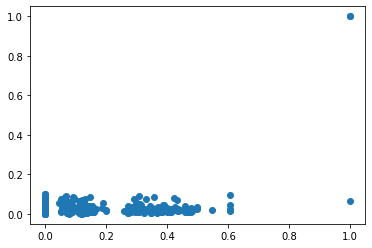

In [55]:
#scatter plot of cosine similarity of ppmi of window size 1 with lin similarity measure
reps1, reps2=getCommonCosPairs(linsimList,ppmi1)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [56]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['cosine similarity ppmi window 1']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,cosine similarity ppmi window 1
lin sim,1.000000,0.024836
cosine similarity ppmi window 1,0.024836,1.000000


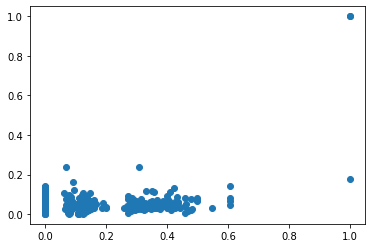

In [60]:
#scatter plot of cosine similarity of ppmi of window size 5 with lin similarity measure
ppmi5=convert_to_ppmi(sentences,5)
reps1, reps2=getCommonCosPairs(linsimList,ppmi5)
plt.scatter([tup[2] for tup in reps1[:1000]],[tup[2] for tup in reps2[:1000]])

In [61]:
scatterDF=pd.DataFrame()
scatterDF['lin sim']=[tup[2] for tup in reps1]
scatterDF['cosine similarity ppmi window 5']=[tup[2] for tup in reps2]
scatterDF.corr(method='spearman')

,lin sim,cosine similarity ppmi window 5
lin sim,1.00000,0.05208
cosine similarity ppmi window 5,0.05208,1.00000


## Semantic vs Distributional similarities:
Semantic similarity relies on some pre-existing knowledge resources (here wordnet thesaurii)

However distributional similarity relies solely on the distributional properties of words from the given corpora. A big disadvantage of distributional methods is that they find word similarities that might only make sense in the context of the corpora.

Combination of the 2 measures can lead to a very high performance.

In [320]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/Colab Notebooks/ANLPassignment.ipynb"
question_count=754

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1509
